In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('max_columns', 100)
%matplotlib inline

In [171]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [172]:
def standardize_nan(x):
    x_mean = np.nanmean(x)
    x_std = np.nanstd(x)
    return (x - x_mean) / x_std

In [173]:
def add_dummies(obj, source, drop_unknown=True):
    col_name = source.name
    dummies = pd.get_dummies(source, prefix=col_name)
    name_unknown = col_name + '_unknown'
    if drop_unknown == True:
        if name_unknown in dummies.columns:
            dummies.drop([name_unknown], axis=1, inplace=True)
    return pd.concat([obj, dummies], axis=1, sort=False)

In [174]:
def add_yn_map(obj, source):
    yn = source.map({'yes':1, 'no':0})
    return pd.concat([obj, yn], axis=1, sort=False)

In [175]:
df_train_raw = pd.read_csv('../input/train.csv')
df_test_raw = pd.read_csv('../input/test.csv')
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()
train_len = len(df_train)

## 外れ値

In [176]:
outliers = df_train[df_train.balance>80000]
outliers = pd.concat([outliers, df_train[df_train.duration>4000]], axis=0)
outliers = pd.concat([outliers, df_train[df_train.previous>100]], axis=0)
df_train = df_train.drop(outliers.index, axis=0)

In [177]:
df_train.to_csv('./trian_without_outliers.csv', index=False)

# データ整形

dfではindexは振り直される

In [178]:
train_len = len(df_train)
df = pd.concat([df_train, df_test], axis=0, ignore_index=True, sort=False)
df_new = pd.DataFrame(df['y']).copy()

## 連続値

- age : 年齢

In [179]:
df_new['age_log'] = np.log(df.age)
df_new['age_log'] = standardize_nan(df_new['age_log'])

- balance : 年間平均残高

In [180]:
df_new['balance_p'] = df['balance'].where(df.balance>0, np.nan)
df_new['balance_m'] = df['balance'].where(df.balance<0, np.nan)

df_new['balance_p'] = np.log(df_new['balance_p'])
df_new['balance_m'] = np.log(-df_new['balance_m'])

df_new['balance_p'] = standardize_nan(df_new['balance_p'])
df_new['balance_m'] = standardize_nan(df_new['balance_m'])

In [181]:
df_new['balance_sign'] = np.sign(df['balance'])

- day : 最終接触日  
外す

- duration : 最終接触時間（秒）

In [182]:
df_new['duration_log'] = np.log1p(df['duration'])
df_new['duration_log'] = standardize_nan(df_new['duration_log'])

- campaign : 現キャンペーンにおける接触回数

In [183]:
df_new['campaign_cut'] = df['campaign'].where(df.campaign<5, 5)
df_new['campaign_log'] = np.log(df['campaign'])

- pdays : 経過日数：前キャンペーン接触後の日数

-1はおかしい  
変な処理で丸められている

In [184]:
df_new['pdays_minus'] = df['pdays'].where(df.pdays==-1, 0)

In [185]:
df_new['pdays_log'] = df['pdays'].where(df.pdays!=-1, np.nan)
df_new['pdays_log'] = np.log(df_new['pdays_log'])
df_new['pdays_log'] = standardize_nan(df_new['pdays_log'])

- previous : 接触実績：現キャンペーン以前までに顧客に接触した回数

In [186]:
df_new['previous_log'] = np.log1p(df['previous'])

In [187]:
df_new['previous_zero'] = df['previous'].where(df.previous==0, 1)

### previous + campaign

In [188]:
df_new['contact'] = df['previous'] + df['campaign']

In [192]:
df_new['contact_log'] = np.log(df_new['contact'])

プロット用に出力

In [193]:
df_new.to_csv('./df_new_1.csv', index=False)

### nanを埋める

nanは-遠方で埋める

In [125]:
df_new['balance_p'] = df_new['balance_p'].fillna(-10)
df_new['balance_m'] = df_new['balance_m'].fillna(-10)

In [126]:
df_new['pdays_log'] = df_new['pdays_log'].fillna(-10)

In [127]:
df_new.to_csv('./df_new_2.csv', index=False)

## ドロップ

In [128]:
#df_new.drop(['balance_m', 'pdays_log', 'previous_log'], axis=1, inplace=True)

In [129]:
df_new.to_csv('./df_new_3.csv', index=False)

## 離散値

- job - 職種
- marital : 未婚/既婚
- education : 教育水準
- default : 債務不履行があるか yes/no
- housing : 住宅ローン yes/no
- loan : 個人ローン yes/no
- contact : 連絡方法

In [130]:
df_new = add_dummies(df_new, df.job)
df_new = add_dummies(df_new, df.marital)
df_new = add_dummies(df_new, df.education)

In [131]:
df_new = add_yn_map(df_new, df.default)
df_new = add_yn_map(df_new, df.housing)
df_new = add_yn_map(df_new, df.loan)

unknownに有意な差

In [132]:
df_new = add_dummies(df_new, df.contact, drop_unknown=False)

- month : 最終接触月

In [133]:
df['month'] = df['month'].map({'jan':1,
                       'feb':2,
                       'mar':3,
                       'apr':4,
                       'may':5,
                       'jun':6,
                       'jul':7,
                       'aug':8,
                       'sep':9,
                       'oct':10,
                       'nov':11,
                       'dec':12
                      })

In [134]:
df_new = add_dummies(df_new, df.month)

- poutcome : 前回のキャンペーンの成果

In [135]:
df_new = add_dummies(df_new, df.poutcome)

In [144]:
df_new['duration_bin'] = pd.cut(df_new.duration_log, bins=8)

In [148]:
y_map = df_new.groupby('duration_bin').y.mean()

In [150]:
df_new['duration_bin'] = df_new['duration_bin'].map(y_map)

In [154]:
df_new['duration_bin'] = (df_new['duration_bin']*100).astype(int)

## 学習

In [155]:
df_new.columns

Index(['y', 'age_log', 'balance_p', 'balance_m', 'balance_sign',
       'duration_log', 'campaign_cut', 'campaign_log', 'pdays_minus',
       'pdays_log', 'previous_log', 'previous_zero', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'default', 'housing',
       'loan', 'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'duration_bin'],
      dtype='object')

In [156]:
X = df_new.drop(['y'], axis=1)[:train_len].values
y = df_new['y'][:train_len].values

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [158]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

In [159]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

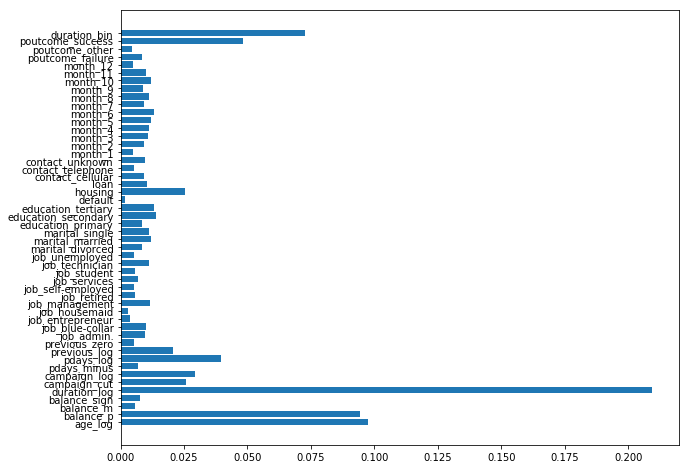

In [160]:
feature_names = df_new.drop(['y'], axis=1).columns
n_features = len(feature_names)
plt.figure(figsize=(10, 8))
plt.barh(range(n_features), rfc.feature_importances_ , align='center')
plt.yticks(np.arange(n_features), feature_names)
plt.show()

#### 勾配Boosting木

### 予測スコア

In [161]:
y_train_pred = rfc.predict_proba(X_train)
y_test_pred = rfc.predict_proba(X_test)

In [162]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_train_pred[:,1]))
print(roc_auc_score(y_test, y_test_pred[:,1]))

1.0
0.9212809623563484


## 提出

In [163]:
X_sub = df_new.drop(['y'], axis=1)[train_len:].values

In [164]:
len(X_sub)

18083

In [165]:
y_sub_pred = rfc.predict_proba(X_sub)
y_sub_pred = y_sub_pred[:,1]

In [166]:
submission = pd.Series(y_sub_pred, index=np.arange(1, len(y_sub_pred)+1))

In [167]:
submission.head()

1    0.54
2    0.63
3    0.00
4    0.01
5    0.05
dtype: float64

In [168]:
submission.to_csv('../output/submission.csv')